<a href="https://colab.research.google.com/github/Bilkouristas/oxf-vis-25/blob/master/VIS_LAB3_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Detection and segmentation

This lab focuses on employing advanced computer vision techniques, specifically object detection, to count the number of cars in an image, and instance segmentation, to identify and anonymize people in images.


## Part 1: Car counting

The first section of the lab involves identifying and counting cars within the images. This task demonstrates how instance segmentation can be applied to different objects and used for extracting analytical information, providing insights into the versatility and utility of computer vision techniques in analyzing and understanding visual data.

Using a pre-trained **Yolo-v5 model** from PyTorch Hub (see details here: https://pytorch.org/hub/ultralytics_yolov5/), you will now focus on detecting and counting cars in the dataset. This task involves processing images to detect objects classified as cars, extracting their segmentation masks, and then counting the number of cars detected in each image.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.0 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gdown

import warnings
warnings.filterwarnings("ignore", message=".*torch.cuda.amp.autocast.*")

In [ ]:
gdown.download("https://drive.google.com/uc?id=1XYTyJURsQYledZSjdo2YsMInztDkMRK2", "oxford_buildings.zip")
!unzip "oxford_buildings.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1XYTyJURsQYledZSjdo2YsMInztDkMRK2
From (redirected): https://drive.google.com/uc?id=1XYTyJURsQYledZSjdo2YsMInztDkMRK2&confirm=t&uuid=a4a8a4a3-5681-4a29-8c83-5548eaa778a5
To: /content/oxford_buildings.zip
100%|██████████| 80.8M/80.8M [00:02<00:00, 32.7MB/s]


Archive:  oxford_buildings.zip
   creating: identified/
  inflating: identified/all_souls_000001.jpg  
  inflating: identified/all_souls_000005.jpg  
  inflating: identified/all_souls_000008.jpg  
  inflating: identified/all_souls_000013.jpg  
  inflating: identified/all_souls_000015.jpg  
  inflating: identified/all_souls_000016.jpg  
  inflating: identified/all_souls_000019.jpg  
  inflating: identified/all_souls_000021.jpg  
  inflating: identified/all_souls_000027.jpg  
  inflating: identified/all_souls_000035.jpg  
  inflating: identified/all_souls_000039.jpg  
  inflating: identified/all_souls_000040.jpg  
  inflating: identified/all_souls_000044.jpg  
  inflating: identified/all_souls_000045.jpg  
  inflating: identified/all_souls_000047.jpg  
  inflating: identified/all_souls_000060.jpg  
  inflating: identified/all_souls_000061.jpg  
  inflating: identified/all_souls_000062.jpg  
  inflating: identified/all_souls_000073.jpg  
  inflating: identified/all_souls_000084.jpg  
  in

In [ ]:
# You might find obtaining the model class names to be useful
model = torch.hub.load('ultralytics/yolov5', 'yolov5l', pretrained=True)
model.names

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-11-12 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 89.3M/89.3M [00:02<00:00, 35.1MB/s]

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients, 109.0 GFLOPs
Adding AutoShape... 


{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [ ]:
def detect_and_count(image_dir, model='yolov5l', class_id=0):
    """
    Detects and counts cars in images within a specified directory using a specified YOLO model.

    Parameters:
    - image_dir: Directory containing images to process.
    - model: YOLO model variant to use for detection.
    """
    # Load the YOLO model with the specified variant, set to pretrained
    model = torch.hub.load('ultralytics/yolov5', model, pretrained=True)

    # Process each image in the specified directory
    for image_path in os.listdir(image_dir):
        # Check if the file is an image based on its extension
        if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Perform detection
            image = cv2.imread(os.path.join(image_dir, image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Step 1: Perform a forward pass through the model
            results = model(image)

            # Step 2: Define a threshold for considering a detection to be confident
            threshold = 0.8  # Placeholder for you to specify a confidence threshold

            # Step 3: Check if cars are detected within the image and set the Boolean cars_detected
            # Hint: results.xyxy[0] contains a vector [xmin, ymin, xmax, ymax, confidence, class_id]
            cars_detected = list((x[-1] == class_id) and (x[-2] > threshold) for x in results.xyxy[0])

            # Print a message if cars are detected in the image, and optionally results.show() to see the images
            # if cars_detected:
            #     print(f'Cars detected in {image_path}.')

            # Print a message if cars are detected in the image, and optionally results.show() to see the images
            if any(cars_detected):
                print(f'{sum(cars_detected)} Cars detected in {image_path}.')
                results.show()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-11-12 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients, 109.0 GFLOPs
Adding AutoShape... 


2 Cars detected in oxford_003565.jpg.


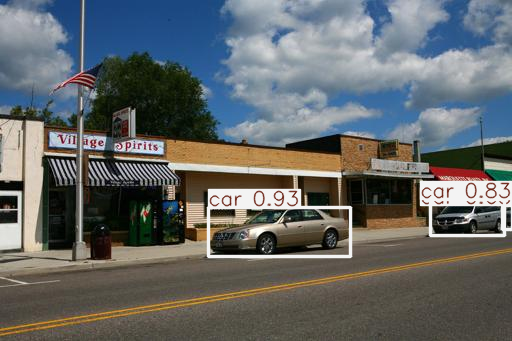

2 Cars detected in oxford_001359.jpg.


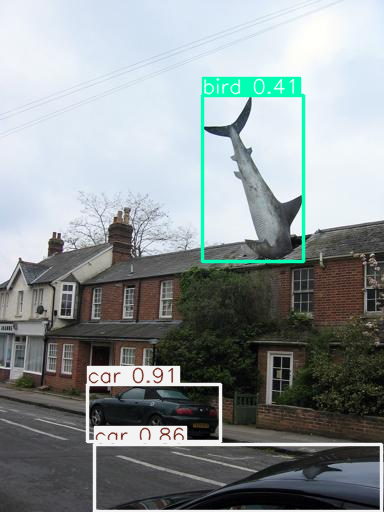

1 Cars detected in oxford_002662.jpg.


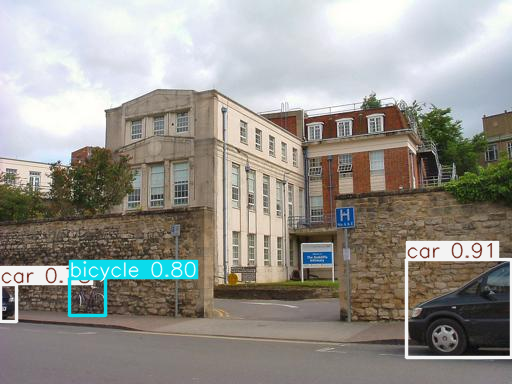

1 Cars detected in oxford_003189.jpg.


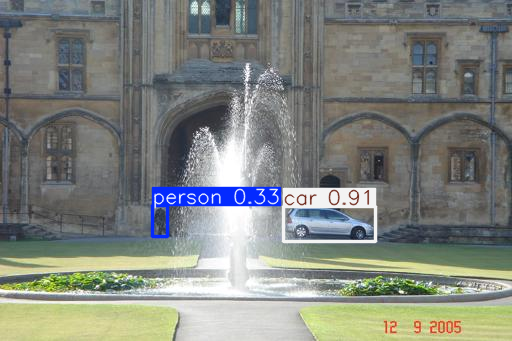

3 Cars detected in oxford_003642.jpg.


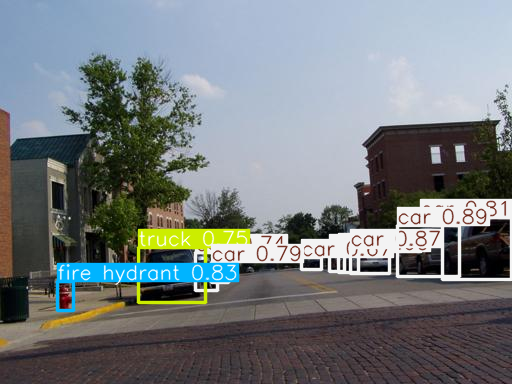

1 Cars detected in oxford_001384.jpg.


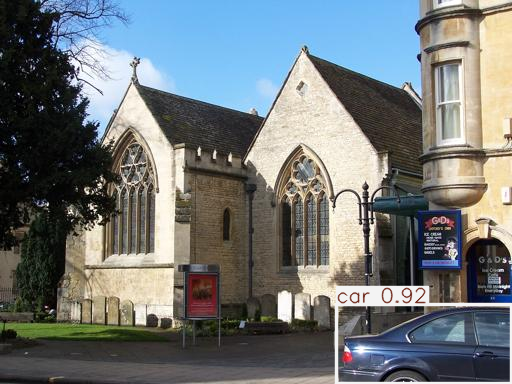

2 Cars detected in oxford_001666.jpg.


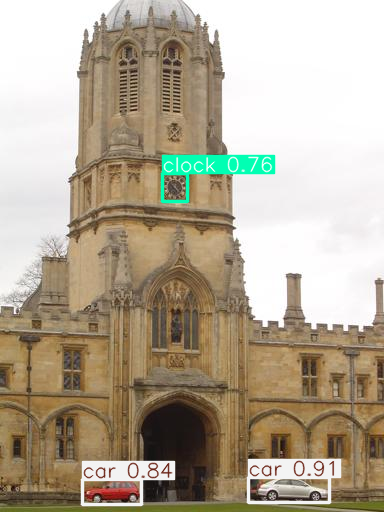

3 Cars detected in oxford_002349.jpg.


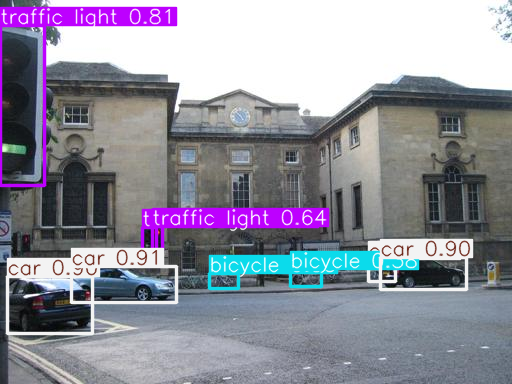

3 Cars detected in oxford_002345.jpg.


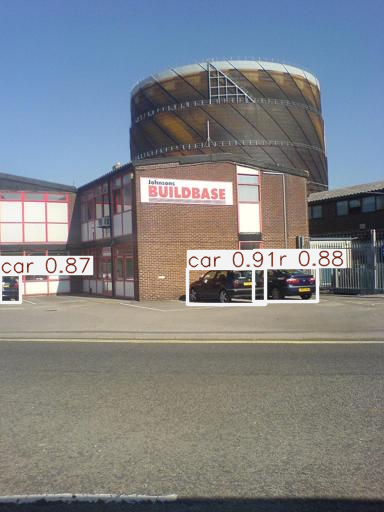

1 Cars detected in oxford_000978.jpg.


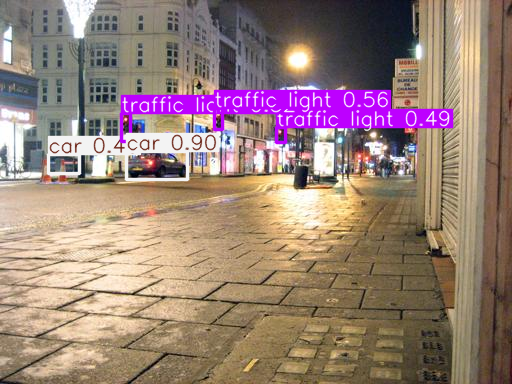

1 Cars detected in oxford_003578.jpg.


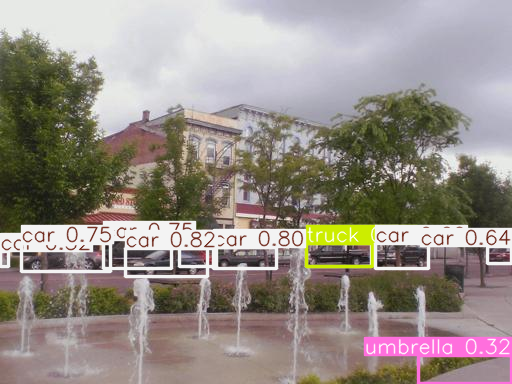

2 Cars detected in oxford_001542.jpg.


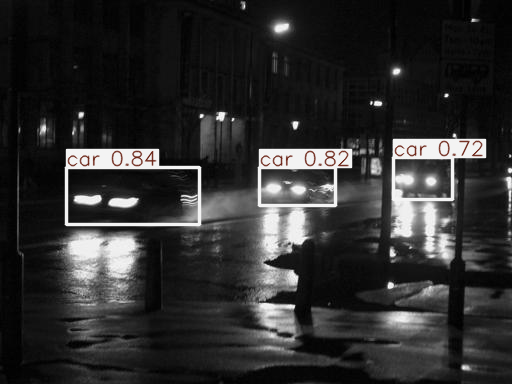

1 Cars detected in oxford_001045.jpg.


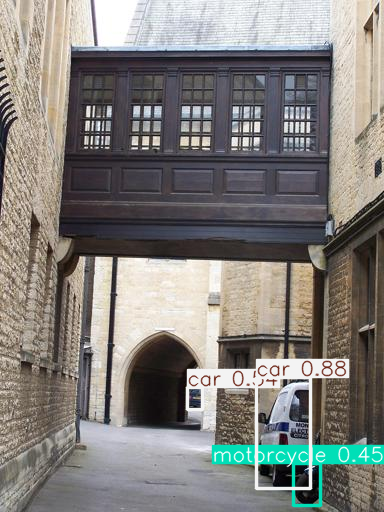

3 Cars detected in oxford_000410.jpg.


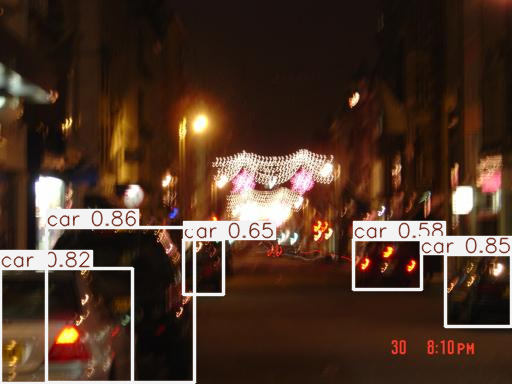

1 Cars detected in oxford_002719.jpg.


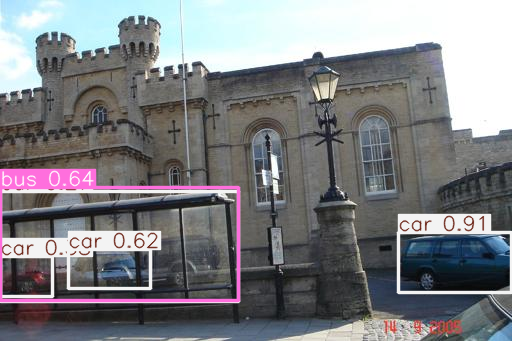

In [ ]:
class_id = 2 # Replace the class_id with the one corresponding with cars
detect_and_count('/content/unidentified', class_id=class_id)

array([[[232, 236, 245],
        [232, 236, 245],
        [232, 236, 245],
        ...,
        [217, 230, 249],
        [216, 229, 248],
        [216, 229, 248]],

       [[232, 236, 245],
        [232, 236, 245],
        [233, 237, 246],
        ...,
        [217, 230, 249],
        [216, 229, 248],
        [216, 229, 248]],

       [[232, 236, 245],
        [233, 237, 246],
        [233, 237, 246],
        ...,
        [218, 231, 250],
        [217, 230, 249],
        [217, 230, 249]],

       ...,

       [[ 47,  47,  47],
        [ 52,  52,  52],
        [ 54,  54,  54],
        ...,
        [  6,   7,  12],
        [  3,   4,   9],
        [  1,   2,   7]],

       [[ 45,  45,  45],
        [ 51,  51,  51],
        [ 53,  53,  53],
        ...,
        [ 23,  24,  29],
        [ 20,  21,  26],
        [ 18,  19,  24]],

       [[ 44,  44,  44],
        [ 50,  50,  50],
        [ 52,  52,  52],
        ...,
        [ 35,  36,  41],
        [ 34,  35,  40],
        [ 33,  34,  39]]], dtype=uint8)
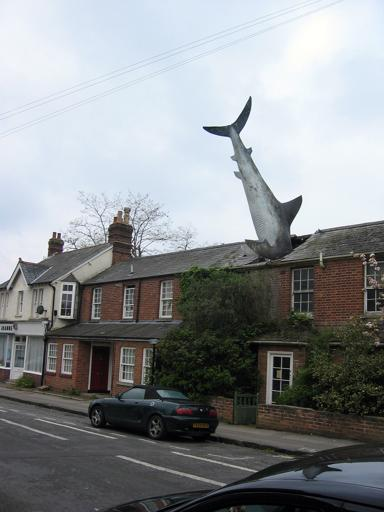

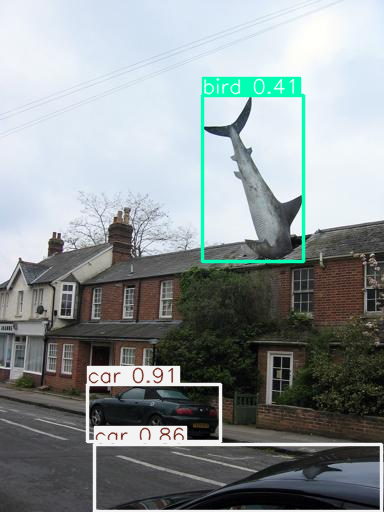

In [ ]:
car_img_path = '/content/unidentified/oxford_001359.jpg'
car_img = cv2.imread(car_img_path)
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
display(car_img)

results = model(car_img)
results.show()

### Further Exploration:
* Play around with different class ids and see how well YOLO performs on other classes.
* Saying if there is a car in the image is good, but it might be more useful to detect *how many* cars are in the image. How do you extend above to include the number of cars inside the image?
* For many different applications such as self-driving, robotics, manufacturing, etc., we need to know where exactly the object is in the image. What are some specific instances that might warrant determining the specific location in the image?
    * You should see that YOLO outputs the bounding boxes for each given image. Can you overlay a bounding box of the object onto the image and display it?

## Part 2: People segmentation and anonymisation

Publicly available image datasets have become a cornerstone for training and evaluating computer vision models. One example is the Oxford Buildings Dataset used in the previous lab, which, like many others, is composed of images collected from publicly accessible sources. However, they often inadvertently capture individuals who were in the vicinity of the scene being photographed. This raises significant privacy issues, especially when the identity of these individuals is not relevant to the dataset's intended task.

As we leverage publicly sourced images for academic and research purposes, it becomes crucial to anonymize any identifiable information about people present in these images. Anonymizing images serves a dual purpose: it addresses privacy concerns and ensures that the dataset remains focused on its intended task, free from personally identifiable data (PID). This process aligns with the principles of responsible AI development, emphasizing the need for privacy-preserving techniques in handling data. By using a pre-trained Mask R-CNN model with PyTorch and applying blurring effects to segmented areas, we aim to remove PID.


In [ ]:
gdown.download("https://drive.google.com/uc?id=12ykyGq4i__1JaG_pQIWBuvhgOsGNif7g", "oxford_w_people.zip")
!unzip "oxford_w_people.zip"

Downloading...
From (original): https://drive.google.com/uc?id=12ykyGq4i__1JaG_pQIWBuvhgOsGNif7g
From (redirected): https://drive.google.com/uc?id=12ykyGq4i__1JaG_pQIWBuvhgOsGNif7g&confirm=t&uuid=f2eeb130-46b8-4a40-a9b0-f316684d4375
To: /content/oxford_w_people.zip
100%|██████████| 91.7M/91.7M [00:00<00:00, 121MB/s] 


Archive:  oxford_w_people.zip
   creating: people/
  inflating: people/trinity_000371.jpg  
  inflating: people/magdalen_000229.jpg  
  inflating: people/trinity_000365.jpg  
  inflating: people/bodleian_000398.jpg  
  inflating: people/oxford_001828.jpg  
  inflating: people/balliol_000162.jpg  
  inflating: people/magdalen_000201.jpg  
  inflating: people/magdalen_000215.jpg  
  inflating: people/trinity_000359.jpg  
  inflating: people/new_001080.jpg   
  inflating: people/oxford_003030.jpg  
  inflating: people/oxford_000539.jpg  
  inflating: people/bodleian_000429.jpg  
  inflating: people/radcliffe_camera_000001.jpg  
  inflating: people/new_000361.jpg   
  inflating: people/new_000407.jpg   
  inflating: people/new_001057.jpg   
  inflating: people/jesus_000306.jpg  
  inflating: people/christ_church_000653.jpg  
  inflating: people/jesus_000312.jpg  
  inflating: people/oxford_000511.jpg  
  inflating: people/trinity_000173.jpg  
  inflating: people/oxford_002689.jpg  
  infla

Mask R-CNN extends Faster R-CNN by adding a branch for predicting segmentation masks on each Region of Interest (RoI), providing detailed instance segmentation.

In [ ]:
# Step 1: Initialize the model with the pre-trained weights
# Hint: Use the appropriate function from torchvision.models.detection
model = maskrcnn_resnet50_fpn(pretrained=True)

# Step 2: Move the model to the GPU if available
# Hint: Check if CUDA is available via torch.cuda.is_available(), and move the model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Step 3: Set the model to evaluation mode
# Hint: Use .eval() method on the model to set it for inference
model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:00<00:00, 199MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

Load and prepare an image for the model, converting it into a format suitable for processing.

In [ ]:
# Load the image
image_path = '/content/people/hertford_000011.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Now, the image is ready to be processed and displayed if needed

# Step 1: Normalize the image by dividing by 255.0 to bring the pixel values between [0, 1]
norm_image = image / 255.

# Step 2: Use torch.from_numpy() to convert the numpy image to a torch tensor
image_tensor = torch.from_numpy(norm_image)

# Step 3: Rearrange the dimensions of the tensor from [H, W, C] to [C, H, W] format using .permute()
image_permuted = image_tensor.permute(2, 0, 1)
print(image_permuted.shape)

# Stpe 4: Add an extra dimension to the tensor using .unsqueeze() to simulate a batch size of 1
image_tensor = image_permuted.unsqueeze(0)
print(image_tensor.shape)

# Step 5: Convert the image_tensor to be of dtype 'float32' and place it onto the device
image_tensor = image_tensor.float().to(device)

torch.Size([3, 512, 384])
torch.Size([1, 3, 512, 384])


Segment People in the Image: Use the loaded model to perform instance segmentation, identifying people within the image and extracting their masks. See here for the model details: https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html

Like YOLO, Mask R-CNN also uses the COCO class names but with a small shift to the indices. What does Mask R-CNN have this shift for?

-- both have the same COCO classes, but YOLO only predicts foreground objects, while mask-rcnn predicts an additional background class that represents no object at all i.e. class_id=0 -> background.

In [ ]:
# Ensure we don't update model weights during inference (saves GPU memory)
with torch.no_grad():
    # Perform inference using the model
    # Note: You need to preprocess your image into a tensor and pass it to your model
    # predictions = model(___)  # Placeholder for you to fill in
    predictions = model(image_tensor)

# Initialize an empty list to hold masks for detected people
people_masks = []

# Loop through each prediction to extract masks for people
# Note: The model's predictions typically include masks, labels, and other details
# You will need to filter these based on the label for 'person' which is often represented by a specific number (e.g., 1)
for mask, label in zip(predictions[0]['masks'], predictions[0]['labels']):
    # Check if the label corresponds to a person
    # Hint: You might want to check what numerical value represents a person in your model's label scheme
    if label == 1:  # Placeholder for you to fill in with the correct label ID for 'person'
        # If the label is for a person, append the mask to the people_masks list
        people_masks.append(mask)

# At this point, people_masks will contain the masks for detected people

Apply Gaussian blur to the areas identified as people using the segmentation masks, accurately anonymizing individuals.

In [ ]:
# First, make a copy of the original image to preserve it
blurred_image = image.copy()

# Loop through each mask in people_masks
for mask in people_masks:
    # Convert the mask to a binary mask based on a threshold
    # Hint: If you want to determine if a pixel is part of an object (person), what should the confidence threshold be?
    threshold = 0.5   # Adjust the threshold if necessary
    binary_mask = mask[0] > threshold

    # Iterate over each color channel (RGB channels) to apply the blurring effect
    for i in range(3):
        # Apply blurring to the area of the image defined by the binary mask
        # Hint 1: Use np.where to select which pixels to blur based on the binary_mask
        # Hint 2: cv2.GaussianBlur is used to blur the selected pixels.
        # Since you want to anonymize the person, how large should your kernel size and standard deviation be?
        blurred_image[:, :, i] = np.where(binary_mask.cpu().numpy(),
                  cv2.GaussianBlur(blurred_image[:, :, i], (23, 23), 30),
                  blurred_image[:, :, i])

        # draw bounding box
        pos = np.where(binary_mask.cpu().numpy())
        x1, y1 = pos[1].min(), pos[0].min()
        x2, y2 = pos[1].max(), pos[0].max()
        cv2.rectangle(blurred_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

Display the modified image with blurred individuals or save it to a file.

array([[[184, 178, 156],
        [183, 177, 155],
        [177, 170, 151],
        ...,
        [198, 200, 197],
        [154, 162, 164],
        [147, 158, 162]],

       [[186, 180, 158],
        [184, 178, 156],
        [178, 171, 152],
        ...,
        [205, 207, 204],
        [174, 182, 184],
        [171, 182, 186]],

       [[187, 180, 161],
        [185, 178, 159],
        [179, 172, 153],
        ...,
        [214, 216, 213],
        [192, 200, 202],
        [187, 198, 202]],

       ...,

       [[ 49,  54,  47],
        [ 53,  58,  51],
        [ 63,  68,  62],
        ...,
        [131, 135, 138],
        [131, 135, 138],
        [130, 134, 137]],

       [[ 47,  54,  46],
        [ 59,  66,  58],
        [ 73,  80,  73],
        ...,
        [129, 133, 136],
        [131, 135, 138],
        [132, 136, 139]],

       [[ 52,  59,  51],
        [ 67,  74,  66],
        [ 82,  89,  82],
        ...,
        [127, 131, 134],
        [131, 135, 138],
        [134, 138, 141]]], dtype=uint8)
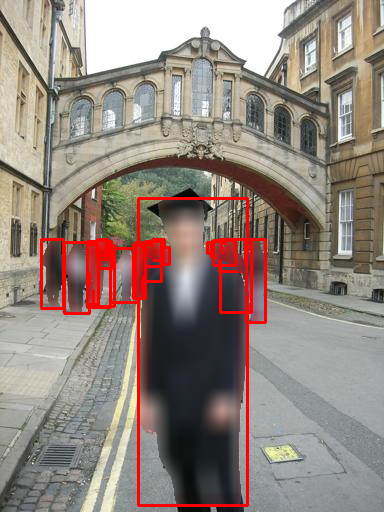

In [ ]:
display(blurred_image)

### Questions for Further Exploration

* Why is instance segmentation preferred over bounding box detection for anonymizing people in images?
* Discuss the potential privacy and ethical considerations when applying these techniques in real-world scenarios.
* Explore how the choice of blurring parameters (e.g., kernel size, sigma in GaussianBlur) affects the anonymization quality.
